In [1]:
!pip install gdown
!gdown --id 1SX2BFJ9lizIyKJDvSV97wEzjQtfR29dv

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1SX2BFJ9lizIyKJDvSV97wEzjQtfR29dv
To: /kaggle/working/Dataset.zip
100%|██████████████████████████████████████| 2.76G/2.76G [00:28<00:00, 95.2MB/s]


In [ ]:
!unzip '/kaggle/working/Dataset.zip' -d '/kaggle/working/'

In [3]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
print("Num CPU Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPU Available:  1
Num GPUs Available:  1


# Model

In [5]:
# Initialize the base model.
# Set the input shape and remove the dense layers.
xception_model = tf.keras.applications.xception.Xception()
xception_model.summary()

91884032/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [6]:
last_output = xception_model.get_layer('block14_sepconv2_act').output

pre_trained_model = tf.keras.Model(xception_model.input, last_output)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [7]:
def model_creator(dense_num):
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten(name = 'flatten')(pre_trained_model.output)
  # Add a fully connected layer with 4 hidden units and ReLU activation
  x = tf.keras.layers.Dense(dense_num, activation='relu', name = 'dense_first')(x)
  # Add a dropout rate of 0.25
  x = tf.keras.layers.Dropout(0.25)(x)                  
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)           

  # Append the dense network to the base model
  model = tf.keras.Model(pre_trained_model.input, x) 

  return model

# Print the model summary. See your dense network connected at the end.
model = model_creator(4)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

# Dataset

In [8]:
TRAINING_DIR = "/kaggle/working/train"
VALIDATION_DIR = "/kaggle/working/validation"
TEST_DIR = '/kaggle/working/test'

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(299,299),
	class_mode='binary',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(299,299),
	class_mode='binary',
  batch_size=32
)

test_generator = validation_datagen.flow_from_directory(
	TEST_DIR,
	target_size=(299,299),
	class_mode='binary',
  batch_size=32
)

Found 7726 images belonging to 2 classes.
Found 966 images belonging to 2 classes.
Found 966 images belonging to 2 classes.


# Find Optimal LR

In [9]:
# finding appropreate learning rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8 * 10 ** (epoch/20)
)

model.compile(optimizer='adam' , loss='binary_crossentropy')

In [10]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    callbacks=[lr_schedule],
                    epochs = 100,
                    verbose = 1)

Epoch 1/100
242/242 [==============================] - 225s 886ms/step - loss: 0.7005 - val_loss: 0.6543 - lr: 1.0000e-08
Epoch 2/100
242/242 [==============================] - 211s 873ms/step - loss: 0.6884 - val_loss: 0.6491 - lr: 1.1220e-08
Epoch 3/100
242/242 [==============================] - 211s 874ms/step - loss: 0.6862 - val_loss: 0.6435 - lr: 1.2589e-08
Epoch 4/100
242/242 [==============================] - 212s 874ms/step - loss: 0.6757 - val_loss: 0.6369 - lr: 1.4125e-08
Epoch 5/100
242/242 [==============================] - 209s 863ms/step - loss: 0.6681 - val_loss: 0.6301 - lr: 1.5849e-08
Epoch 6/100
242/242 [==============================] - 211s 871ms/step - loss: 0.6616 - val_loss: 0.6227 - lr: 1.7783e-08
Epoch 7/100
242/242 [==============================] - 207s 857ms/step - loss: 0.6518 - val_loss: 0.6142 - lr: 1.9953e-08
Epoch 8/100
242/242 [==============================] - 211s 871ms/step - loss: 0.6346 - val_loss: 0.6046 - lr: 2.2387e-08
Epoch 9/100
242/242 [===

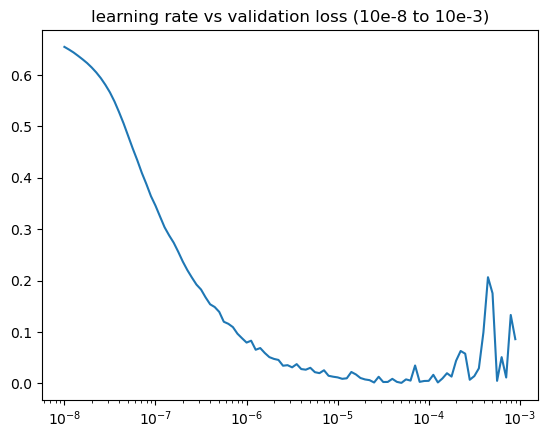

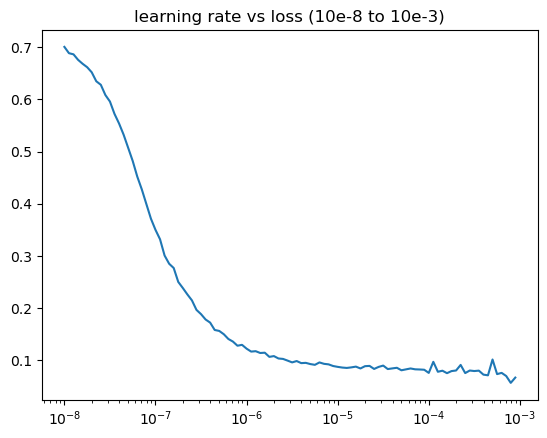

<Figure size 640x480 with 0 Axes>

In [11]:
#plot learning rate schedule

lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs , history.history['val_loss'])
plt.title('learning rate vs validation loss (10e-8 to 10e-3)')
plt.figure()
plt.semilogx(lrs , history.history['loss'])
plt.title('learning rate vs loss (10e-8 to 10e-3)')
plt.figure()

plt.show()

# Training

In [13]:
# Re-define the model to train with the optimal learning rate

model = model_creator(4)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6) , 
                loss='binary_crossentropy', metrics = ['acc'])

In [15]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [16]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=50,
                    callbacks = [early_stopping_cb],
                    verbose = 1)

Epoch 1/50
242/242 [==============================] - 215s 875ms/step - loss: 0.4402 - acc: 0.7912 - val_loss: 0.2521 - val_acc: 0.9296
Epoch 2/50
242/242 [==============================] - 211s 871ms/step - loss: 0.2199 - acc: 0.9182 - val_loss: 0.1824 - val_acc: 0.9462
Epoch 3/50
242/242 [==============================] - 210s 869ms/step - loss: 0.1578 - acc: 0.9412 - val_loss: 0.1325 - val_acc: 0.9648
Epoch 4/50
242/242 [==============================] - 213s 878ms/step - loss: 0.1307 - acc: 0.9478 - val_loss: 0.1151 - val_acc: 0.9658
Epoch 5/50
242/242 [==============================] - 211s 872ms/step - loss: 0.1171 - acc: 0.9556 - val_loss: 0.1014 - val_acc: 0.9710
Epoch 6/50
242/242 [==============================] - 211s 872ms/step - loss: 0.1115 - acc: 0.9524 - val_loss: 0.0860 - val_acc: 0.9783
Epoch 7/50
242/242 [==============================] - 212s 878ms/step - loss: 0.0982 - acc: 0.9565 - val_loss: 0.0721 - val_acc: 0.9834
Epoch 8/50
242/242 [============================

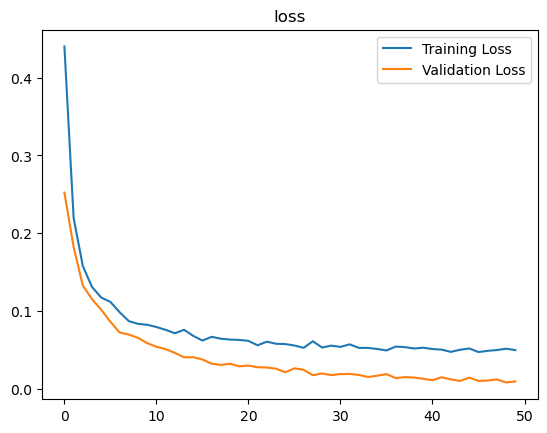

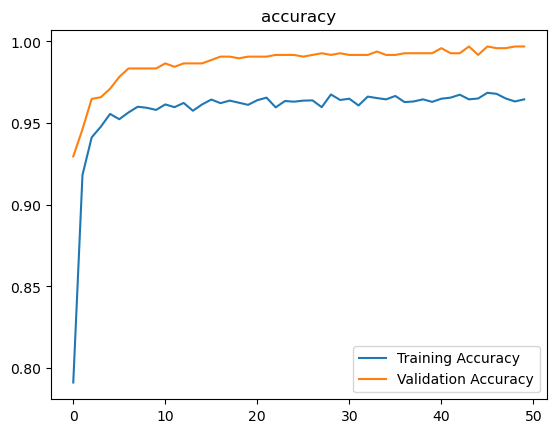

In [17]:
#plot acc and loss

model.save('/kaggle/working/xception.h5')

epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['loss'], label='Training Loss')
plt.plot(epochs , history.history['val_loss'], label='Validation Loss')
plt.title('loss')
plt.legend()

plt.figure()

plt.plot(epochs , history.history['acc'], label='Training Accuracy')
plt.plot(epochs , history.history['val_acc'], label='Validation Accuracy')
plt.title('accuracy')
plt.legend()

plt.show()

# Statistics

In [18]:
test_generator.class_indices

{'covid': 0, 'normal': 1}

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5) , 
                loss='binary_crossentropy', metrics = ['acc',
                                                      tf.keras.metrics.AUC(),
                                                      tf.keras.metrics.Precision(),
                                                      tf.keras.metrics.Recall(),
                                                      tf.keras.metrics.TruePositives(),
                                                      tf.keras.metrics.TrueNegatives(),
                                                      tf.keras.metrics.FalsePositives(),
                                                      tf.keras.metrics.FalseNegatives()])

In [20]:
a = model.evaluate(test_generator)

31/31 [==============================] - 11s 283ms/step - loss: 0.0065 - acc: 0.9990 - auc: 1.0000 - precision: 0.9981 - recall: 1.0000 - true_positives: 522.0000 - true_negatives: 443.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00


In [21]:
conf_mx = [[a[6], a[7]],[a[8], a[5]]]
mx = np.array(conf_mx)
fscore = 2*a[3]*a[4]/(a[3]+a[4])
spc = mx[0, 0] * 1.0 / (mx[0, 0] + mx[0, 1])
sen = mx[1,1] * 1.0 / (mx[1,1] + mx[1,0])

print('accuracy:',np.round(a[1]*100,2),'%')
print('precision:',np.round(a[3]*100,2),'%')
print('recall:',np.round(a[4]*100,2),'%')
print('Sensitivity:',np.round(sen*100,2),'%')
print('Specificity:',np.round(spc*100,2),'%')
print('f1-score:',np.round(fscore*100,2),'%')
print('AUC:',np.round(a[2]*100,2),'%')

accuracy: 99.9 %
precision: 99.81 %
recall: 100.0 %
Sensitivity: 100.0 %
Specificity: 99.77 %
f1-score: 99.9 %
AUC: 100.0 %
